In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.output_stderr').hide();
 } else {
 $('div.input').show();
 $('div.output_stderr').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action='javascript:code_toggle()'><input STYLE='color: #4286f4' 
type='submit' value='Click here to toggle on/off the raw code.'></form>''')

# <center> Citation network </center>

## Introduction

Many phenomena in the world can be mapped to networks. In this report I am going to analyze the citation network based on [aMiner](https://aminer.org/citation). 

## Dependencies

Since these kind of networks can grow really huge (and therefore the necessity of power of computation), python is not the most efficient coding language. Fortunately, there is a package that uses C/C++ codes for computation, however has a python interface also. [graph_tool](https://graph-tool.skewed.de/) uses docker to do this. To access the environment on the local machine also, one needs to run the docker (see basic instructions [here](https://git.skewed.de/count0/graph-tool/wikis/installation-instructions#jupyter-notebooks) ) in such a way that __instead of the following code:__

~~~
docker run -p 8888:8888 -p 6006:6006 -it -u user -w /home/user tiagopeixoto/graph-tool bash
~~~

one uses this:

~~~
docker run -p 8888:8888 -p 6006:6006 -it -u user -w /home/user -v /home/<YOUR USERNAME>:/home/user tiagopeixoto/graph-tool bash
~~~

With this, one can append the anaconda's environment to the system's path (see code cells below). Other basic python dependencies can also be found in the cells below.

In [2]:
import sys
sys.path.append('/home/user/anaconda3/lib/python3.7/site-packages')
sys.path.append('/home/user/graph-tool-2.29/src/')
sys.path.append('/home/user/pkgs/')

In [3]:
%pylab inline
from graph_tool.all import *
import pandas as pd
from tqdm import tqdm
from collections import Counter,defaultdict
import networkx as nx
import pickle
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


## Loading in the data

The data provided is stored as a text file with hashmarks indicating which type of information is in that line. Further information about the storing can be found at the [official webpage](https://aminer.org/citation) at the Description section. In the code cell below (commented out) I loaded in the data and tried to store that in a dataframe. This took plenty of time, so in order to save it, I had exported it out as a $\texttt{pickle}$ object. 

In [4]:
## In this code cell I read in the smallest amount of data provided
# yet I was still not able to process and store all of that in a pandas
# dataframe. Since it is a computationally very expensive procedure, 
# (processing only a quarter of the data took more than an hour)
# I recommend not to run this again. Load in df_papers.p instead.

"""with open('citation-network1/outputacm.txt') as f:
    data = f.readlines()

del data[0] ## only the number of points

line_decoder = {"#*": "title", "#@" : "authors", "#t" : "year", "#c" : "pub_venue",
               "#i" : "index", "#%" : "ref_ids", "#!" : "abstract", "\n" : "new_line"}

def makeitusable(d):
    linetype = line_decoder.get(d[:2])
    if linetype != "new_line":
        d = d[2:-1]
    else:
        return  "--------------", linetype
    if linetype == "authors":
        return d.split(sep = ','), linetype
    elif linetype == "year":
        return int(d), linetype
    elif linetype == "ref_ids":
        return int(d), linetype
    elif linetype == "index":
        return int(d[4:]), linetype
    else:
        return d, linetype
    

df = pd.DataFrame(columns=line_decoder.values())
df.drop(['new_line', "pub_venue", "abstract"], axis = 1, inplace = True)

upload = {}
for c, d in tqdm(enumerate(data)):
    usable, linetype = makeitusable(d)
    if linetype == "new_line":
        df = df.append(upload, ignore_index=True)
        upload.clear()
    elif linetype == "ref_ids":
        try:
            upload[linetype].append(usable)
        except KeyError:
            upload[linetype] = [usable]
    elif linetype not in ['pub_venue', 'abstract']:
        upload[linetype] = usable
#        print(f"{linetype} : {usable}")
pickle.dump( df, open( "df_papers.p", "wb" ) )
""";

In [5]:
df = pickle.load( open( "df_papers.p", "rb" ) )

Here you can see how the original data looked like. I dropped the publication venue and the abstract coloumn. 

In [6]:
df.head()

,title,authors,year,index,ref_ids
0,Automated Deduction in Geometry: 5th Internati...,"[Hoon Hong, Dongming Wang]",2006,0,NaN
1,A+ Certification Core Hardware (Text & Lab Man...,[Charles J. Brooks],2003,1,NaN
2,Performance engineering in industry: current p...,"[Ahmed E. Hassan, Parminder Flora]",2007,2,NaN
3,"Dude, You Can Do It! How to Build a Sweeet PC","[Darrel Creacy, Carlito Vicencio]",2005,3,NaN
4,What Every Programmer Needs to Know about Secu...,"[Neil Daswani, Anita Kesavan]",2006,4,NaN


Below you can see all the papers listed in which Hoon Hoong was an author. 

In [7]:
for i in range(len(df)):
    if "Hoon Hong" in df.iloc[i].authors:
        print(df.iloc[i])

title      Automated Deduction in Geometry: 5th Internati...
authors                           [Hoon Hong, Dongming Wang]
year                                                    2006
index                                                      0
ref_ids                                                  NaN
Name: 0, dtype: object
title      Connectivity in semialgebraic sets (abstract o...
authors                            [Robert Quinn, Hoon Hong]
year                                                    2008
index                                                  43372
ref_ids                                                  NaN
Name: 43372, dtype: object
title      Proceedings of the second international sympos...
authors                          [Hoon Hong, Erich Kaltofen]
year                                                    1997
index                                                  74503
ref_ids                                                  NaN
Name: 74503, dtype: object
title   

In [8]:
print(f"The shape of the dataframe: {df.shape}")

The shape of the dataframe: (150560, 5)


The next step is to construct the network. First, I am going to create a bipartite network. The two kinds of nodes will be the authors and the papers, edges will be drawn between an author and a paper if the person is one of the authors of that particular article. Authors will only have a name as a property, but for papers we have the following information kept:
~~~
title, year, references.
~~~
To create the network I used graph_tool. 

In [9]:
## make a graph
## create a graph
g = Graph(directed=False)
## define node properties
## name: papers - title, authors - 'name'
## kind: papers - 0, authors - 1
name = g.vp["name"] = g.new_vp("string")
kind = g.vp["kind"] = g.new_vp("int")

docs_add = defaultdict(lambda: g.add_vertex())
words_add = defaultdict(lambda: g.add_vertex())

# iterate throug all the rows
verbose = True
N = len(df)
for i in range(N):
    d = docs_add[df.iloc[i].title]
    name[d] = df.iloc[i].title
    kind[d] = 0
    for a in df.iloc[i].authors:
        c = words_add[a]
        name[c] = a
        kind[c] = 1
        g.add_edge(d,c)
    if verbose:
        print(i/N, end = '\r')

In [10]:
# g.save("small_graph.graphml") # safety first
# g = load_graph("small_graph.graphml") # and second

Here I converted it into networkx-type graph. Below you can see a summary about the basic information of the properties of this bipartite graph.

In [11]:
G = nx.read_graphml("small_graph.graphml") # convert into networkx-type network

In [12]:
# printings
print(nx.info(G))
print(f"Standard dev. of degrees: {std(g.get_total_degrees(g.get_vertices()))}")
print(f"Clustering coeff: {global_clustering(g)[0]}")
g_rand = g.copy()
random_rewire(g_rand, model='erdos')
print(f"Diameter: {pseudo_diameter(g)[0]}. Logarithm of the # nodes: {log(len(g.get_vertices()))}")
print(f"Diameter of the same ER: {pseudo_diameter(g_rand)[0]}, and clustering coeff: {global_clustering(g_rand)[0]}")

Name: 
Type: MultiGraph
Number of nodes: 364447
Number of edges: 352105
Average degree:   1.9323
Standard dev. of degrees: 17.11046887235077
Clustering coeff: 0.0
Diameter: 74.0. Logarithm of the # nodes: 12.806136415194644
Diameter of the same ER: 1.0, and clustering coeff: 4.4134976527548314e-06


The clustering coefficient is zero. This is not true for real network. The reason behind this the fact that here we used bipartite graph. An average degree is not so informative without the distribution. Real world networks are scale-free meaning their degree distribution is scaling i.e. their degree distribution can be characterized with a power-law function:

$$
p(k) = c \cdot k^{-\gamma},
$$

where $p(k)$ is the probability that a randomly chosen node has degree $k$, $\gamma$ is the scaling factor and $c$ is a norming parameter.

Another important property a real-world networks have is that they are small-world networks i.e. their diameter (longest shortest path) is in the range of the logarithm of the number of nodes: 

$$
d_{max} \sim \log{N}.
$$

In [13]:
# fitting powerlaw
hist = nx.degree_histogram(G)

x,y = [], []
for i in range(len(hist)):
    if hist[i] != 0 and 2< i < 100:
        x.append(log(i))
        y.append(log(hist[i]))

gamma, b = np.polyfit(x,y,1)

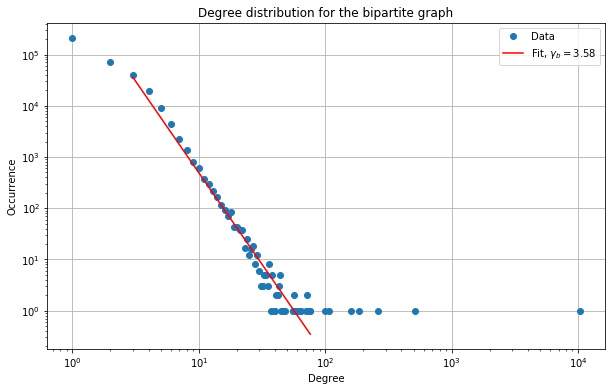

In [14]:
# plotting degdist
plt.figure(figsize=(10,6))
plt.plot(range(len(hist)), hist, 'o', label = 'Data')
plt.plot(exp(x),exp([i*gamma + b for i in x]), 'r-', label = f"Fit, $\gamma_b = ${np.round(-gamma,2)}")
plt.xlabel("Degree")
plt.ylabel("Occurrence")
plt.title("Degree distribution for the bipartite graph")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(loc = 'best')
plt.show()

The above picture shows the degree distribution for the bipartite graph. Please note that the axes are logarithmic, and therefore the scaling property is clearly seen. The fitted $\gamma_b$ scaling parameter is going to be discussed with the unipartite graph's. I made a threshold for fitting since there are anomalies both at the beginning and at the end. 

## Author-author network

In the following part I am going to create a network where the nodes are the authors and edges are drawn between them if they have an article in common.

In [15]:
def create_unipartite(g, kind, name, k_type, verbose = False):
    ## make a graph
    ## create a graph
    g2 = Graph(directed=False)
    ## define node properties
    ## name: docs - title, words - 'word'
    ## kind: docs - 0, words - 1
    name2 = g2.vp["name"] = g2.new_vp("string")
    #kind2 = g2.vp["kind"] = g2.new_vp("int")

    docs_add = defaultdict(lambda: g2.add_vertex())
    #words_add = defaultdict(lambda: g.add_vertex())
    
    N = len(list(g.vertices()))
    
    for i,v in enumerate(g.vertices()):
        if kind[v] == k_type:
 #           print(kind[v], name[v])
            d = docs_add[name[v]]
            name2[d] = name[v]
            for f in v.all_neighbors():
                for w in f.all_neighbors():
                    if w!=i:
#                        print(f"neighs: {kind[w]}, {name[w]}")
                        r = docs_add[name[w]]
                        name2[r] = name[w]
                        g2.add_edge(d,r)
        if verbose:
            print(f"Generating unipartite graph: {np.round(100*(i+1)/N, 2)}%", end = '\r')
    return g2, name2

In [16]:
g2, name2 = create_unipartite(g, kind, name, 1, verbose=True)

In [17]:
# g2.save("asd.graphml") # safety first

In [18]:
G2 = nx.read_graphml("asd.graphml")

The generated unipartite author-author graph has the following properties:

In [19]:
# printings
print(nx.info(G2))
print(f"Standard dev. of degrees: {std(g2.get_total_degrees(g2.get_vertices()))}")
print(f"Clustering coeff: {global_clustering(g2)[0]}")
g2_rand = g2.copy()
random_rewire(g2_rand, model='erdos', n_iter=3)
print(f"Diameter: {pseudo_diameter(g2)[0]}. Logarithm of the # nodes: {log(len(g2.get_vertices()))}")
print(f"Diameter of the same ER: {pseudo_diameter(g2_rand)[0]}, and clustering coeff: {global_clustering(g2_rand)[0]}")

Name: 
Type: MultiGraph
Number of nodes: 215983
Number of edges: 937196
Average degree:   8.6784
Standard dev. of degrees: 38.363776569131076
Clustering coeff: 0.5153107955364336
Diameter: 37.0. Logarithm of the # nodes: 12.2829549798653
Diameter of the same ER: 10.0, and clustering coeff: 4.126656419622006e-05


The number of nodes decreased whilst the edges have grown. It is possible since here we did allow to have multiple edges. The average degree and its standard deviation have increased also, and the clustering coefficient, too. The diameter decreased a lot, but compared to the E-R random graph, the clustering coefficient is decreased also. 

In [20]:
hist = nx.degree_histogram(G2)

x,y = [], []
for i in range(len(hist)):
    if hist[i] != 0 and 10< i < 300:
        x.append(log(i))
        y.append(log(hist[i]))

gamma, b = np.polyfit(x,y,1)

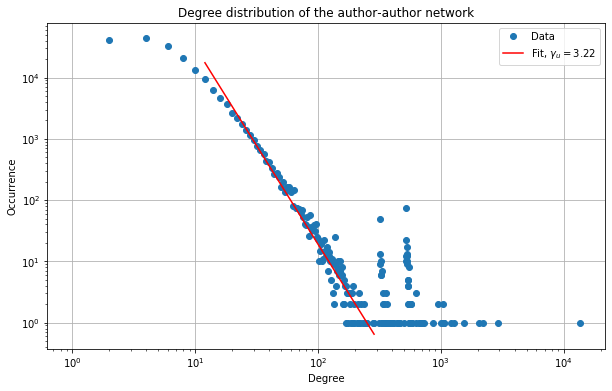

In [21]:

plt.figure(figsize=(10,6))
plt.plot(range(len(hist)), hist, 'o', label = 'Data')
plt.plot(exp(x),exp([i*gamma + b for i in x]), 'r-', label = f"Fit, $\gamma_u = ${np.round(-gamma,2)}")
plt.xlabel("Degree")
plt.ylabel("Occurrence")
plt.title("Degree distribution of the author-author network")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(loc = 'best')

plt.show()

The histogram shows a decrease in the scaling coefficient, but there are some anomalies. These spikes perhaps could be eliminated if I could load in the overall dataset or a newer one. 

The figure below (from Barabási-Albert's slides) shows how real-world network's scaling factors are distributed. B-A shows the Barabási-Albert model. Our coefficients are way far from the real $\gamma_{collab}$, but since both the average degree an its standard deviation increased indicating a good tendency towards divergence. 

![](scaling_things.png)

## Conclusions

Unfortunately I could not process all the data therefore the temporal evolution could not be examined. The results based on these data are promising, tend to indicate the real-world examples.